In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ---------------------------------------- 0.0/138.3 kB ? eta -:--:--
     -------------------------------------- 138.3/138.3 kB 8.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     --- ------------------------------------ 0.2/2.1 MB 5.9 MB/s eta 0:00:01
     ---------- ----------------------------- 0.5/2.1 MB 6.8 MB/s eta 0:00:01
     --------------- ------------------------ 0.8/2.1 MB 6.3 MB/s eta 0:00:01
     ---------------------- ----------------- 1.2/2.1 MB 6.8 MB/s eta 0:00:01
     --------------------------- ------------ 1.5/2.1 MB 6.6 MB/s eta 0:00:01
     -------------------------------- ------- 1.7/2.1 MB 6.5 MB/s eta 0:00:01
     -------------------------------------- - 2.1/2.1 MB 6.5 MB/s eta 0:00:01
     ---------------------------------------- 2.1/2.1 MB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/198.2 kB ? eta -:--:--
     -------------------------------------- 198.2/198.2 kB 6.1 MB/s eta 0:00:00

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
def read_image(path):
    # TODO: Open the image in RGB format and convert into numpy array
    image = Image.open(path).convert('RGB')
    image = np.array(image)
    
    # TODO: Normalize the image
    image = image/255
    
    return image

In [5]:
image = read_image('image.png')
# TODO: Get shape of image
print(image.shape)

(382, 774, 3)


In [6]:
original_bytes = image.nbytes
print ("The space (in bytes) needed to store this image is", original_bytes)

The space (in bytes) needed to store this image is 7096032


In [7]:
def SVD_channels(image):
    
  # TODO: Separate the channels of the image
  image_red = image[:,:,0]
  image_green = image[:,:,1]
  image_blue = image[:,:,2]

  # Perform SVD on each channel
  U_r, S_r, V_r = np.linalg.svd(image_red, full_matrices=False)
  U_g, S_g, V_g = np.linalg.svd(image_green, full_matrices=False)
  U_b, S_b, V_b = np.linalg.svd(image_blue, full_matrices=False)
  
  return U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b

In [8]:
U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)
bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b]])
print ("The matrices that we store have total size (in bytes):", bytes_to_be_stored)

The matrices that we store have total size (in bytes): 10607376


In [9]:
def TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k):
  # TODO: Use only top K eignevectors. Top K in U, S, V in all channels

    U_r_k = U_r[:, :k]
    V_r_k = V_r[:k, :]
    S_r_k = np.diag(S_r[:k])

    U_g_k = U_g[:, :k]
    V_g_k = V_g[:k, :]
    S_g_k = np.diag(S_g[:k])

    U_b_k = U_b[:, :k]
    V_b_k = V_b[:k, :]
    S_b_k = np.diag(S_b[:k])

    return U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k

In [10]:
U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k=10)

compressed_bytes = sum([matrix.nbytes for matrix in [U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k]])
print ("The compressed matrices that we store now have total size (in bytes):", compressed_bytes)

The compressed matrices that we store now have total size (in bytes): 279840


In [11]:
ratio = compressed_bytes / original_bytes
print ("The compression ratio between the original image size and the total size of the compressed factors is", ratio)

The compression ratio between the original image size and the total size of the compressed factors is 0.039436124301581506


In [12]:
def reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k):
  # TODO: Reconstruct the image from compressed U, S, V matrices.

  image_red_approx = U_r_k @ S_r_k @ V_r_k
  image_green_approx = U_g_k @ S_g_k @ V_g_k
  image_blue_approx = U_b_k @ S_b_k @ V_b_k

  image_approx = np.zeros((382, 774, 3))
  image_approx = np.stack([image_red_approx, image_green_approx, image_blue_approx], axis=2)

  return image_approx

In [13]:
image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

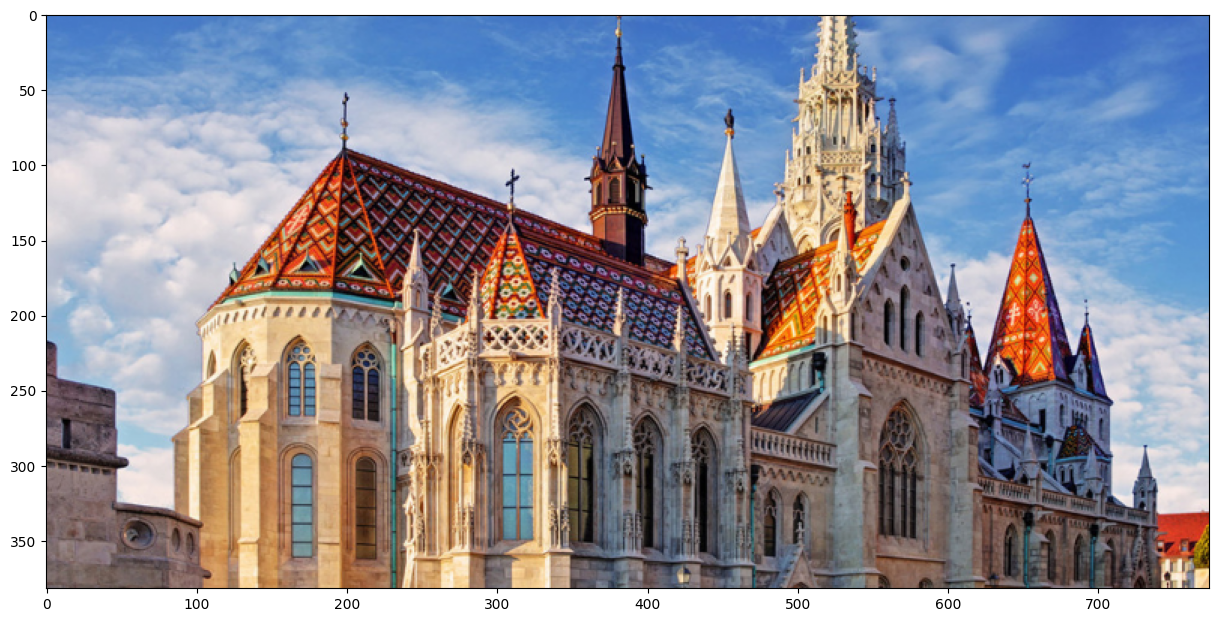

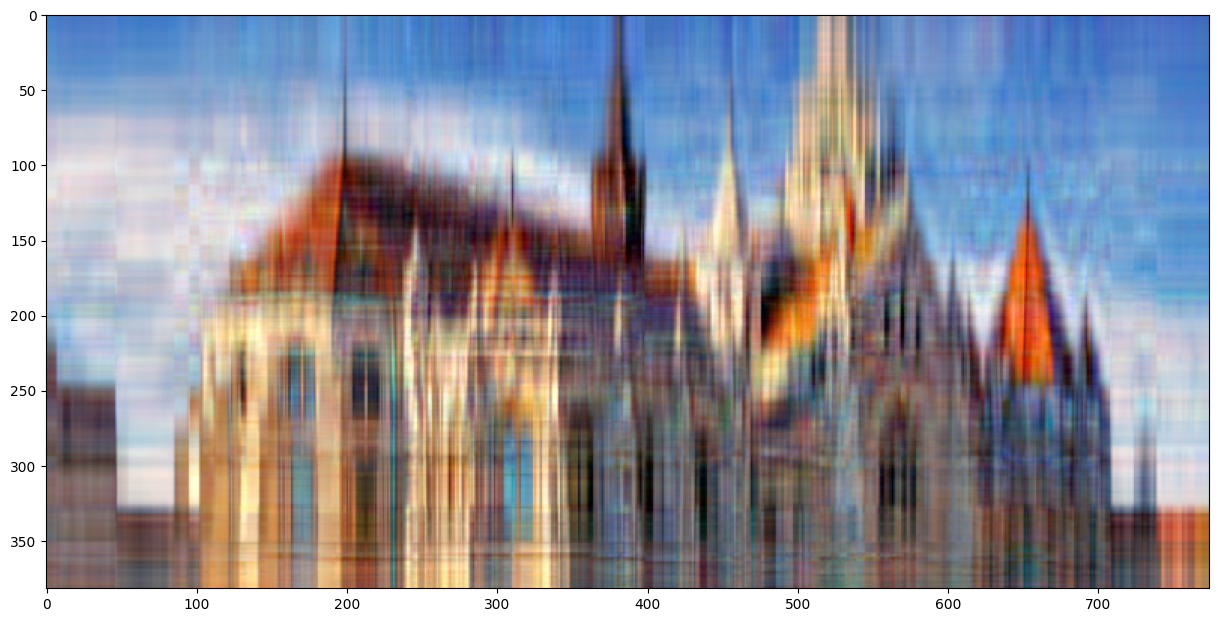

In [14]:
# fig = plt.figure(figsize=(15, 10))
# a = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.figure(figsize=(15, 10))
plt.imshow(image_reconstructed)
# a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
# plt.show()

In [16]:
@interact(k=widgets.IntSlider(min=0, max=300, step=5))
def image_compressor(k):
  image = read_image('image.png')
  U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)

  U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k)

  image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

  image_reconstructed[image_reconstructed < 0] = 0
  image_reconstructed[image_reconstructed > 1] = 1

  plt.figure(figsize=(15, 10))

  plt.imshow(image_reconstructed)

# interact(image_compressor);

interactive(children=(IntSlider(value=0, description='k', max=300, step=5), Output()), _dom_classes=('widget-i…